## 1. Introduction and hypothesis

The problem I aim to work on is examining the evolution of literary themes in American fiction from 1789 to 1875. Literature often reflects the culture of the time period in which it existed so this study provides valuable insight into the changes in cultural, societal, and political perspectives over time as reflected by American literature. It also serves to explore what themes and cultural norms constituted the decades in American history, perhaps the texts published in each decade can provide insight into the beliefs and ideologies people held at the time. This study aims to evalute the topics and themes that are prevalent in the corpus and how these evolve over (almost) a century.

Similar research on this topic has been done in the past as can be read in "Theme development in qualitative content analysis and thematic analysis" (Vaismoradi, 2016). In this paper, Vaismoradi defines what "theme" means and what thematic analysis really serves to do as well as the methodologies to go about it. The paper states that "'Theme' is the main product of data analysis that yields practical results in the field of study." It states that researchers consider both latent content as themes and manifest content as categories in data analysis. The paper delineates between theme and category saying that categories are descriptors of themes. In this study, I aim to explore the evolution of more latent content, that is themes, and research what themes are present in texts throughout American fictional literature. The paper further details the methodologies to use in which to go about thematic analysis that is "collecting codes under potential subthemes or themes, and comparing the emerged coding’s clusters together and in relation to the entire data set comprise the main components of data analysis in both methods." This motivated my use of clustering methods, an unsupervised machine learning model, to explore inherent clusters of texts in the dataset. Perhaps, this may give insight into what texts are similar to one another and why. Is it due to the time period? The author's ethnicity? Gender? Whether the author lived in the North or South?

Another interesting study of similar topics is detailed in "Distant Horizons: Digital Evidence and Literary Change" by Ted Underwood (2019). The book details the findings of a divergence of genres in literature throughout history. Underwood conducted this study using predictive statistical model of genres through logistic regression and cross-validation. He noted that models were most accurate when training included the most common words in the corpora. This motivated my use of logistic regression classification in my study. 

In this study, I expect to find that the time period and region in which texts are written as well as gender and ethnicity of the authors will have a significant impact on the themes in the texts displayed through the words most commonly used in the corpora. 

## 2. Data and methods
Corpus, data, and methods. What data have you used? What are the limitations of that data? What major methods will you use to analyze it? Why are those methods the appropriate ones?


### Imports and packages

In [1]:
import os
import re
import pandas as pd
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

In [2]:
# File locations
#   Note that metadata are supplied as a TSV file
#   Text files are in a directory, one file per (long, novel-like) document
metadata_file = (os.path.join('corpus_data.tsv'))
dir_name = 'us_texts'
file_names = os.listdir(dir_name)

In [3]:
# hold texts in a dictionary keyed to file names
texts = {}

# read texts
for fn in file_names:
    with open(os.path.join(dir_name, fn), encoding="utf8") as f:
        texts[fn] = f.read()
        
# print data lengths
print("Number of texts:", len(texts))

Number of texts: 1540


In [4]:
# Load the metadata
metadata = pd.read_csv(
    metadata_file, 
    sep='\t',
    low_memory=False
)

### Corpus details

The cells below are supplied to help you understand the corpus. **You should remove them from your completed exam** and include only the information you deem relevant to your report. That said, you are free to keep the metadata-loading code above and you may copy any and all of the other code below for your own purposes.

In [186]:
# Glance at the metadata
metadata.head(20)

,source_id,author,title,pub_place,publisher,pub_date,gender,gender_guess,ethnicity,occupation,occupation_free,state_born,state_main,state_died,born,died,words
0,eaf001,"Allston, Washington",Monaldi,Boston,C. C. Little and J. Brown,1841,M,0.0,White,Arts,Painter,SC,MA,MA,1779.0,1843.0,47541
1,eaf002,"Bacon, Delia Salter",Tales of the puritans,New Haven [Conn.],A. H. Maltby,1831,F,0.0,White,Education,Teacher,OH,CT,CT,1811.0,1859.0,70010
2,eaf003,"Bacon, Delia Salter",Love's martyr,Cincinnati,Printed by E. Morgan and Co.,1838,F,0.0,White,Education,Teacher,OH,CT,CT,1811.0,1859.0,13547
3,eaf004,"Bacon, Delia Salter",The bride of Fort Edward,New York,Samuel Colman,1839,F,0.0,White,Education,Teacher,OH,CT,CT,1811.0,1859.0,34309
4,eaf005,"Belknap, Jeremy",The foresters,Boston,Printed by I. Thomas and E. T. Andrews,1792,M,0.0,White,Church,Minister,MA,NH,MA,1744.0,1798.0,33731
5,eaf006,"Bennett, Emerson",The bandits of the Osage,Cincinnati,Robinson & Jones,1847,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,104654
6,eaf007,"Bennett, Emerson","Kate Clarendon, or, Necromancy in the wilderness",Cincinnati,Stratton and Barnard,1848,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,71261
7,eaf008,"Bennett, Emerson",The renegade,Cincinnati,Robinson & Jones,1848,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,82322
8,eaf009,"Bennett, Emerson","The trapper's bride, or, Spirit of adventure",Cincinnati,Stratton & Barnard,1848,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,113704
9,eaf011,"Bennett, Emerson","Oliver Goldfinch, or, The hypocrite",Cincinnati,Stratton & Barnard,1850,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,86799


In [9]:
# Summary stats for numeric columns
metadata.describe()

,pub_date,gender_guess,born,died,words
count,1540.000000,1425.000000,1188.000000,1165.000000,1.540000e+03
mean,1853.963636,0.197193,1811.624579,1878.185408,7.584156e+04
std,15.764799,0.398019,17.669353,22.077845,5.916979e+04
min,1789.000000,0.000000,1744.000000,1793.000000,1.667000e+03
25%,1845.000000,0.000000,1804.000000,1860.000000,4.820550e+04
50%,1855.000000,0.000000,1811.000000,1881.000000,6.927450e+04
75%,1867.000000,0.000000,1823.000000,1893.000000,9.377150e+04
max,1875.000000,1.000000,1857.000000,1934.000000,1.150556e+06


### Field definitions and distributional stats

Most of the metadata fields are self-explanatory, but here are some details. Note that not every field in the metadata is described below.

* `source_id`: This is the name of the file corresponding to the volume. You can use it to match metadata records to full-text documents. Note that the corpus includes a nontrivial number of multivolume works. These volumes have `source_id`s like `eaf086v1` or `Wright2-1720v2`.
* `gender`: Author gender. `M`, `F`, or  `NaN` (= unknown).
* `gender_guess`: Was the author gender assignment determined by biographical research (`0`) or by guessing on the basis of the author's name (`1`)?
* `ethnicity`: Author ethnicity. One of `White`, `Black`, `Native`, or `NaN` (= unknown). Always assigned via biographical research. Not very useful, as the values are almost exclusively `White` or `NaN`. This fact tells you something about the US literary field in the nineteenth century.
* `occupation` and `occupation_free`: The author's primary employment identification. Recall that the US in the nineteenth century didn't always have a large market for novels, so many of the authors in the corpus made their living by other means. The difference between these fields is that `occupation` uses a fixed vocabulary, while `occupation_free` does not (so includes more detailed or fine-grained information).
* `state_*`: The state in which the author was `born`, `died`, and with which they are conventionally associated (`main`).
* `born` and `died`: Year of the author's birth and death, respectively, where known.

In [5]:
# Occurrence counts for selected metadata fields
for col in ['gender', 'gender_guess', 'ethnicity', 'occupation', 'state_main']:
    display(metadata[col].value_counts())
    print()

gender
M    1005
F     420
Name: count, dtype: int64

gender_guess
0.0    1144
1.0     281
Name: count, dtype: int64

ethnicity
White     1040
Black        3
Native       3
Name: count, dtype: int64

occupation
Editor-Critic-Journalist        217
Writer                          187
Education                       147
Politics-Government-Activism    136
Church                          121
Military-Seafaring               72
Law                              57
Business-Trade                   33
Medicine                         28
Arts                              6
Agriculture-Land                  6
Name: count, dtype: int64

state_main
NY         286
MA         123
PA          97
MS          74
MD          72
ME          69
DC          38
SC          32
CT          26
OH          23
VA          22
NC          16
NJ          13
MO          11
IL          11
VT           9
IN           8
CA           7
Germany      7
WV           5
LA           5
GA           5
AL           4
MI           3
RI           3
OR           3
KY           3
MN           2
AR           2
TN           2
England      1
Italy        1
TX           1
FL           1
NH           1
CO           1
Name: count, dtype: int64

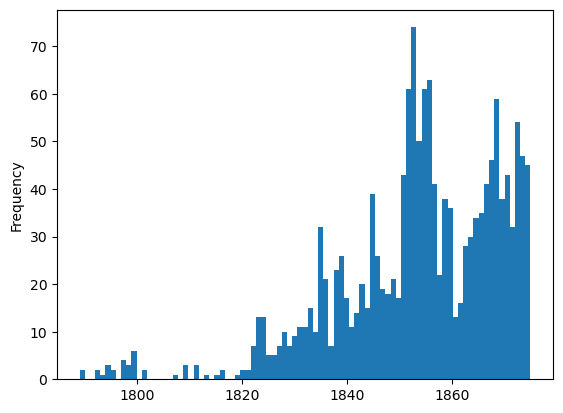

In [6]:
# Distribution of publication dates
metadata.pub_date.plot.hist(bins=metadata.pub_date.max()-metadata.pub_date.min()+1);

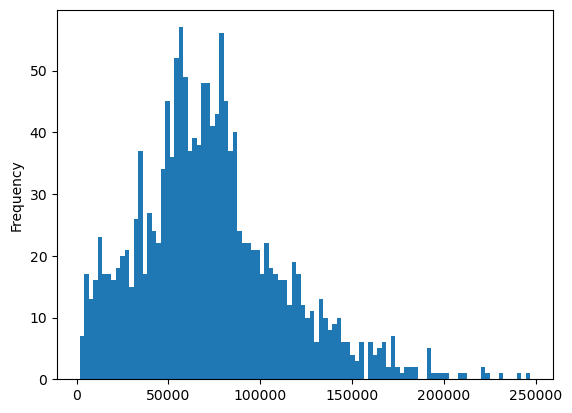

In [7]:
# Distribution of volume lengths
#   Note removal of long volumes from vis
metadata.loc[metadata.words.between(0,250000)].words.plot.hist(bins=100);

The corpus includes some very long and very short volumes. Think about what you want to do with outliers. You'll also want to think about whether or not to break each volume into chunks; this is a good idea for some purposes, but not for others.

### Pre-processing

In this section, I discuss the corpus, data and methods I use. When importing the texts in the first place, I created a dictionary and imported the data into a dictionary format with the 'source_id' being the key and the text itself as the value. However, to make it a more functional data type, in this section I turn the text dictionary into a pandas dataframe adding the metadata like publication date, decade published (extracted from the publication year), gender of the author, ethnicity, and state of residence of the author into the dataframe as well. The purpose of this is to create a centralized data frame in which not only the text itself but additional information about the text can also be accessed. In addition to the original data frame, I also create a sampled set of the data that contains 50% of the original data. The purpose of this is to have a smaller data set I can work with.

In [5]:
# turn text dictionary into pandas dataframe
original = pd.DataFrame.from_dict(texts, orient='index')
data = original.reset_index()
data = data.rename(columns={"index": "source_id", 0: "text"})
year_data = []
gender_data = []
state_data = []
ethnicity_data = []
for text in data['source_id']:
    year_data.append(metadata[metadata['source_id']==text]['pub_date'].item())
    gender_data.append(metadata[metadata['source_id']==text]['gender'].item())
    state_data.append(metadata[metadata['source_id']==text]['state_main'].item())
    ethnicity_data.append(metadata[metadata['source_id']==text]['ethnicity'].item())
decade_data = []
for year in year_data:
    decade_data.append(str(year)[0:3]+'0')
data['pub_date'] = year_data
data['decade'] = decade_data
data['gender'] = gender_data
data['ethnicity'] = ethnicity_data
data['state'] = state_data
print(data)

         source_id                                               text  \
0           eaf001  MONALDI.\nCHAPTER I.\nAmong\nthe students of a...   
1           eaf002  THE REGICIDES\nWe dig no lands for tyrants but...   
2           eaf003  The loved, the hated, the adored,\nEach mortal...   
3           eaf004  2\nTHE BRIDE OF FORT EDWARD.\nPART FIRST.\nIND...   
4           eaf005  LETTER I.\nOriginal State of the\nForest\n.The...   
...            ...                                                ...   
1535  Wright2-2801  BEHIND THE SCENES.\nCHAPTER I.\nTHE CHILD AND ...   
1536  Wright2-2802  ASTOUNDING DISCLOSURES!\nTEMPLES OF THE K. G. ...   
1537  Wright2-2803  ALMOST A PRIEST.\nCHAPTER I.\nGABRIELLE STREET...   
1538  Wright2-2804  THE BEST FELLOW IN THE WORLD.\nCHAPTER I.\nTO ...   
1539  Wright2-2806  HOW COULD HE ESCAPE?\nCHAPTER I.\nTHE WIDOW'S ...   

      pub_date decade gender ethnicity state  
0         1841   1840      M     White    MA  
1         1831   1830      F 

Here, I print the publication years represented in this data set. There is literature from 72 different years (1789 to 1875). 

In [6]:
# how many unique years of publication dates are contained in this dataset?
years = metadata['pub_date'].unique()
years.sort()
print(len(years), "unique years")
print(years)

72 unique years
[1789 1792 1793 1794 1795 1797 1798 1799 1801 1807 1809 1811 1813 1815
 1816 1819 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831
 1832 1833 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845
 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859
 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873
 1874 1875]


In [6]:
# sample 50% of the data
for i in range(len(metadata)):
    grouped_df = metadata.groupby('pub_date').sample(frac=0.5)

first_years = grouped_df.reset_index()
first_years = first_years.set_index(['index'])
first_years.head()

,source_id,author,title,pub_place,publisher,pub_date,gender,gender_guess,ethnicity,occupation,occupation_free,state_born,state_main,state_died,born,died,words
index,,,,,,,,,,,,,,,,,
42,eaf034v1,"Brown, William Hill","The power of sympathy, or, The triumph of natu...",Boston,"Printed in Boston, by Isaish Thomas and Compan...",1789,M,0.0,White,Writer,Writer,MA,MA,NC,1765.0,1793.0,15660
27,eaf022,"Brackenridge, H. H. (Hugh Henry)","Modern chivalry, Vol.2","Carlisle, PA",Printed by Archibald Loudon,1792,M,0.0,White,Law,Judge,Scotland,PA,PA,1748.0,1816.0,99457
364,eaf327,[None],The fille de chambre,Philadelphia,"Printed for H. & P. Rice, No. 50, High-Street;...",1794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71908
362,eaf325,[None],Charlotte,Philadelphia,"Printed for Mathew Carey, No. 118, Market-Street",1794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39443
365,eaf328v1,[None],"Trials of the human heart, Vol. 1",Philadelphia,"Printed for the author, by Wrigley & Berriman....",1795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65800


In [32]:
# create list of source id's for sampled texts
id_list = list(first_years['source_id'])
print(f"There are {len(id_list)} sampled texts")

There are 771 sampled texts


In [8]:
# create data frame of the sampled texts 
df = data[data['source_id'].isin(id_list)] 
year_list = []
gender_list = []
state_list = []
ethnicity_list = []
for text in df['source_id']:
    year_list.append(metadata[metadata['source_id']==text]['pub_date'].item())
    gender_list.append(metadata[metadata['source_id']==text]['gender'].item())
    state_list.append(metadata[metadata['source_id']==text]['state_main'].item())
    ethnicity_list.append(metadata[metadata['source_id']==text]['ethnicity'].item())
decade_list = []
for year in year_list:
    decade_list.append(str(year)[0:3]+'0')
df['pub_date'] = year_list
df['decade'] = decade_list
df['gender'] = gender_list
df['ethnicity'] = ethnicity_list
df['state'] = state_list
decades = df['decade'].unique()
print(df)

         source_id                                               text  \
0           eaf001  MONALDI.\nCHAPTER I.\nAmong\nthe students of a...   
1           eaf002  THE REGICIDES\nWe dig no lands for tyrants but...   
5           eaf006  PART I.\nCHAPTER I.\nINTRODUCTIONTHE TRAVELERS...   
6           eaf007  CHAPTER I.\nChange is written on the tide\nOn ...   
8           eaf009  THE\nTRAPPER'S BRIDE\nCHAPTER I.\nO'er vales t...   
...            ...                                                ...   
1534  Wright2-2767  OUR NIG.\nCHAPTER I.\nMAG SMITH, MY MOTHER.\nO...   
1535  Wright2-2801  BEHIND THE SCENES.\nCHAPTER I.\nTHE CHILD AND ...   
1536  Wright2-2802  ASTOUNDING DISCLOSURES!\nTEMPLES OF THE K. G. ...   
1537  Wright2-2803  ALMOST A PRIEST.\nCHAPTER I.\nGABRIELLE STREET...   
1538  Wright2-2804  THE BEST FELLOW IN THE WORLD.\nCHAPTER I.\nTO ...   

      pub_date decade gender ethnicity state  
0         1841   1840      M     White    MA  
1         1831   1830      F 

C:\Users\emmpa\AppData\Local\Temp\ipykernel_23000\3145483735.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pub_date'] = year_list
C:\Users\emmpa\AppData\Local\Temp\ipykernel_23000\3145483735.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decade'] = decade_list
C:\Users\emmpa\AppData\Local\Temp\ipykernel_23000\3145483735.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

I created a list of all original texts as well as a list of all sampled texts so that I can easily iterate through these texts in future methods. 

In [9]:
# list of all texts
text_list = []
for text in data['text']:
    text_list.append(text)
print(len(text_list))

1540


In [10]:
# list of texts from selected sample of texts
sample_list = []
for text in df['text']:
    sample_list.append(text)
print(len(sample_list))

771


The first method I used is a function that creates the plots of unclustered and clustered models of the text data. This is similar to a method used in PS2. After clustering (shown later), I use plot_compare() to compare the unclustered model of the text data to the clustered model.

In [11]:
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        # TruncatedSVD is fast and can handle sparse inputs
        # PCA requires dense inputs; MDS is slow
        coordinates = TruncatedSVD(n_components=2).fit_transform(X)
    else:
        # Handle 2-D inputs
        coordinates = X
    
    # Set up figure
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    # Unlabeled data
    axs[0].scatter(
        coordinates[:, 0], 
        coordinates[:, 1], 
        alpha=alpha, # Set transparency so that we can see overlapping points
        linewidths=0 # Get rid of marker outlines
    )
    axs[0].set_title("Unclustered data")

    # Labeled data
    axs[1].scatter(
        x=coordinates[:, 0], 
        y=coordinates[:, 1],
        c=labels,
        alpha=alpha,
        #palette='viridis',
        linewidth=0
    )
    axs[1].set_title("Clustered data")
    fig.suptitle(title)
    plt.show()

This method preprocesses the text, lowercasing words, removing punctuation and numbers, and returning a standardized version of the text. 

In [12]:
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    import unicodedata
    x = unicodedata.normalize('NFKD', x)
    x = x.replace("\'", "'").replace("\ in\ form", " inform").lower().strip()
    x = re.sub(r'[^A-Za-z\s]', '', x)  # Remove punctuation and numbers
    return x

Before working with the text data, I vectorize the texts to create feature data and labels. I print the matrix shape as well as use a sample document to test the featurize() method that displays the features of the text passed in. 

In [14]:
# Set up vectorizer
vectorizer = TfidfVectorizer(
    encoding='utf-8',
    preprocessor=pre_proc,
    min_df=2, # Note this
    max_df=0.8, # This, too
    binary=False,
    norm='l2',
    use_idf=True # And this
)

def featurize(text_list, vectorizer):
    X_texts = vectorizer.fit_transform(text_list)

    # Get the dimensions of the doc-term matrix
    print("Matrix shape:", X_texts.shape)

    doc = 100 # Which document to use?
    print("\nA sample document:\n", doc, '\n')
    feature_list = sorted(vectorizer.inverse_transform(X_texts[doc])[0])
    print("The document's features:\n", feature_list)
    
featurize(text_list, vectorizer)

Matrix shape: (1540, 217007)

A sample document:
 100 

The document's features:
 ['abandon', 'abandoned', 'abandoning', 'abate', 'abeam', 'ability', 'aboard', 'abolitionist', 'abraham', 'abreast', 'abroad', 'abrupt', 'abruptly', 'absentees', 'absolute', 'absolutely', 'absorbed', 'absorbing', 'abstain', 'abstained', 'abstraction', 'abundant', 'abuse', 'abused', 'accent', 'accessary', 'accessories', 'accident', 'accidentally', 'acclamation', 'accompany', 'accomplish', 'accomplishment', 'accord', 'accorded', 'accordin', 'accordingly', 'accounts', 'accuracy', 'accurate', 'accursed', 'accusations', 'accuse', 'accused', 'accusers', 'accuses', 'achievement', 'acknowledge', 'acknowledgments', 'acquaintances', 'acquiescence', 'acquiescing', 'acquisition', 'acquit', 'acquitted', 'acted', 'acting', 'active', 'activeminded', 'activity', 'actor', 'actors', 'acts', 'actual', 'actually', 'adaptation', 'adapted', 'addicted', 'adding', 'addition', 'additional', 'adieu', 'adjacent', 'adjourn', 'adjourn

The pull_samples() method is similar to one we used in PS2. It is used after clustering the data to pull out samples from each cluster so that they can be compared. Because clustering is an unsupervised machine learning method, it is unclear how the data is clustered. This method shows what sample texts exist in each cluster which can provide insight to similarities in the texts of each cluster. 

In [46]:
def pull_samples(dct, list_texts, labels, n=3):
    '''
    Takes a dictionary, list of texts, and an array of labels, as well as number of samples to return per label.
    Prints sample texts belonging to each label.
    '''
    texts_array = np.array(list_texts)
    
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        print("Label:", label)
        sample_indices = np.where(labels == label)[0]
        
        if len(sample_indices) >= n:
            chosen = np.random.choice(sample_indices, size=n, replace=False)
        else:
            chosen = sample_indices
        
        for choice in chosen:
            # Use % to wrap around the index if it's out of bounds
            choice_num = choice % len(texts_array)
            print("Sample text:", choice_num)
            for key, val in dct.items():
                if val == texts_array[choice_num]:
                    print("Source ID:", key)
            print(texts_array[choice_num][:500], '\n')
            
        print("###################################")

I created a data frame of the features in the texts grouped by the decade they were published in. This data frame is later used for logistic regression classification to see if the classification model can accurately classify the decade in which the texts were written based on the features/topics in the text.

In [24]:
# Group by 'decade' and join text observations
agg_df = df.groupby('decade')['text'].agg(lambda x: ' '.join(x)).reset_index()

# Preprocess the 'text' column before TF-IDF
vectorizer = TfidfVectorizer(preprocessor=lambda x: x)  # Use a dummy preprocessor to keep the original text
tfidf_matrix = vectorizer.fit_transform(agg_df['text'])

# Creating a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the original DataFrame and the new TF-IDF DataFrame
result_df = pd.concat([agg_df, tfidf_df], axis=1)

In [25]:
result_df

,decade,text,aa,aaa,aaaabsurd,aaabut,aaacowardand,aaademanded,aaado,aaah,...,zwanziges,zweck,zwei,zwicken,zwillinge,zwinger,zymphonies,zyx,zyxhow,zyxs
0,1780,letter i\nharrington to worthy\nboston\nyou\nm...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1790,letter i\noriginal state of the\nforest\nthe\n...,0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1800,letter i\nto henry colden\n\nphiladelphia\n\nm...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1810,alonzo and melissa\na tale\nin\nthe time of th...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1820,fort braddock letters\nletter i\nfort braddock...,0.000020,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1830,the regicides\nwe dig no lands for tyrants but...,0.000015,0.000007,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,...,0.000005,0.000000,0.000000,0.000005,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000
6,1840,monaldi\nchapter i\namong\nthe students of a s...,0.000014,0.000002,0.000003,0.000000,0.000003,0.000003,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1850,oliver goldfinch\nchapter i\nthe hypocrite unm...,0.000006,0.000003,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1860,an outcast\nchapter i\ncharleston\nthis simple...,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,0.000000,0.000004,0.000000,0.000003,0.000002,0.000000,0.000357,0.000003,0.000013
9,1870,seven wives and seven prisons\nchapter i\nthe ...,0.000023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000006,0.000010,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000


There are several limitations of this data. This corpus represents approximately only 40% of the American fiction from the period, implying potential biases in the selection of digitized volumes. Thus, the dataset may not fully capture the diversity of authors and genres prevalent during that time. The analysis also does not account for regional variations in language use. Additionally, because I created a sampled data set, the number of texts from each year and each decade becomes even more limited and causes the findings to be less generalizable. 

As stated above, I will be using clustering and classification to analyze the data. In addition, I will use LDA topic model to display the prevalent topics existent in the data. It is appropriate to use clustering as the purpose of this study is to explore similarities of the texts based on different factors. We can hypothesize what factors these may be but clustering provides a more inherent grouping of texts based on similarities detected on its own. Clustering will allow us to draw conclusions from existent similarity groups rather than grouping the texts on our own. Classification is appropriate as well because it allows us to confirm that a feature of the data such as publication year or author's gender is a valid predictor of the theme and topic of the text. 

## 3. Results
What did you find? How did you find it? How should we read your figures? Be sure to include confidence intervals or other measures of statistical significance or uncertainty where appropriate.

### Clustering

Below, I perform KMeans clustering with 3 clusters and with 5 clusters as well as spectral clustering and density-based clustering (DBSCAN). KMeans clustering simply divides the data up into k number of clusters whereas spectral clustering tilizes the eigenvectors of a similarity matrix to perform dimensionality reduction before clustering and DBSCAN identifies clusters as dense regions separated by sparser areas. To analyze how differently the text can be clustered, we experiment with different clustering methods below. The plots simply provide a visualization of the clusters whereas the text printed below show sample texts from each cluster. 

kMeans label vector shape: (1540,)


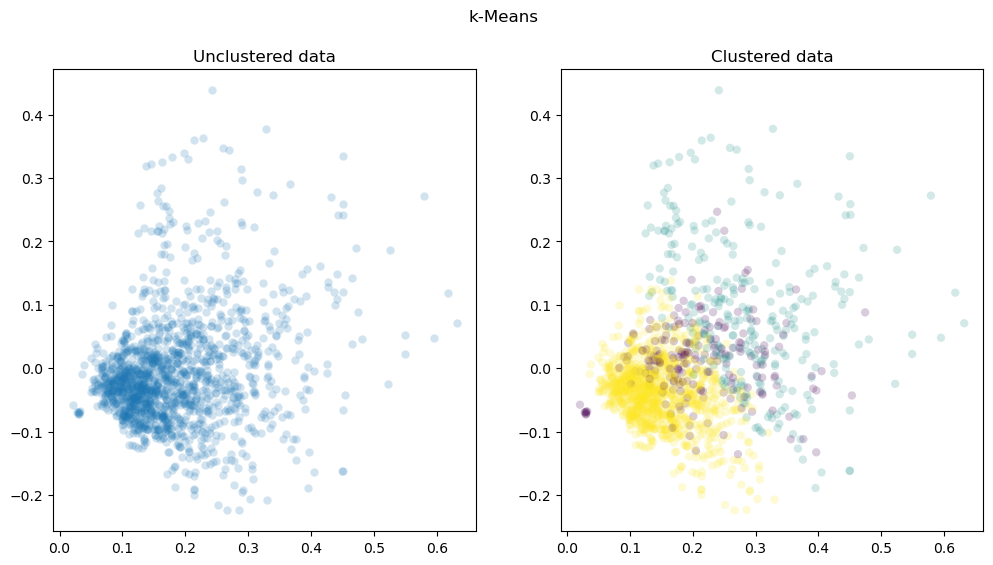

In [15]:
# k-Means clustering with n_clusters = 3
X_texts = vectorizer.fit_transform(text_list)

# Set up clustering object
kmeans = KMeans(n_clusters=3, n_init='auto')

# Perform clustering and return labels
y_kmeans = kmeans.fit_predict(X_texts)

# Print label vector shape
print("kMeans label vector shape:", y_kmeans.shape)

# Plot results 
plot_compare(X_texts, y_kmeans, 'k-Means')

In [16]:
cluster_labels1 = kmeans.labels_

data['cluster'] = cluster_labels1

print(data['cluster'].unique())
data.head(10)

[2 1 0]


,source_id,text,pub_date,decade,gender,ethnicity,state,cluster
0,eaf001,MONALDI.\nCHAPTER I.\nAmong\nthe students of a...,1841,1840,M,White,MA,2
1,eaf002,THE REGICIDES\nWe dig no lands for tyrants but...,1831,1830,F,White,CT,1
2,eaf003,"The loved, the hated, the adored,\nEach mortal...",1838,1830,F,White,CT,2
3,eaf004,2\nTHE BRIDE OF FORT EDWARD.\nPART FIRST.\nIND...,1839,1830,F,White,CT,2
4,eaf005,LETTER I.\nOriginal State of the\nForest\n.The...,1792,1790,M,White,NH,2
5,eaf006,PART I.\nCHAPTER I.\nINTRODUCTIONTHE TRAVELERS...,1847,1840,M,White,NY,2
6,eaf007,CHAPTER I.\nChange is written on the tide\nOn ...,1848,1840,M,White,NY,2
7,eaf008,CHAPTER I.\nINTRODUCTIONTHE STRANGERTHE ATTACK...,1848,1840,M,White,NY,2
8,eaf009,THE\nTRAPPER'S BRIDE\nCHAPTER I.\nO'er vales t...,1848,1840,M,White,NY,1
9,eaf011,OLIVER GOLDFINCH.\nCHAPTER I.\nTHE HYPOCRITE U...,1850,1850,M,White,NY,2


In [ ]:
pull_samples(texts, sample_list, cluster_labels1, 3)

Label: 0
Sample text: 611
Source ID: Wright2-0918
SYBIL CAMPBELL;
OR, THE QUEEN OF THE ISLE.
CHAPTER I.
CAMPBELL'S ISLE.
"The island lies nine leagues away
Along its solitary shore
Of craggy rock and sandy bay
No sound but ocean's roar,
Save where the bold, wild sea-bird makes her home,
Her shrill cry coming through the sparkling foam."
—R. H. DANA.
About six miles from the mainland of M—, with its rock-bound coast washed by the waters of the broad Atlantic, was an islet, known in the days of which I write as Campbell's Isle.
The island was sma 

Sample text: 116
Source ID: eaf195
PART FIRST.
IN PORT.
CHAPTER FIRST.
IN WHICH THE HERO IS INTRODUCED TO THE READER AND SOME DESCRIPTION
OF THE WING OF THE WIND IS GIVEN.
THE scene of the following tale opens in the month of
September
,
1827, at that period when the Colombian revolution was
creating no little sensation in the world, and especially in
the United States,a nation ever foremost to extend its sympathy to
a people struggling for po

kMeans label vector shape: (1540,)


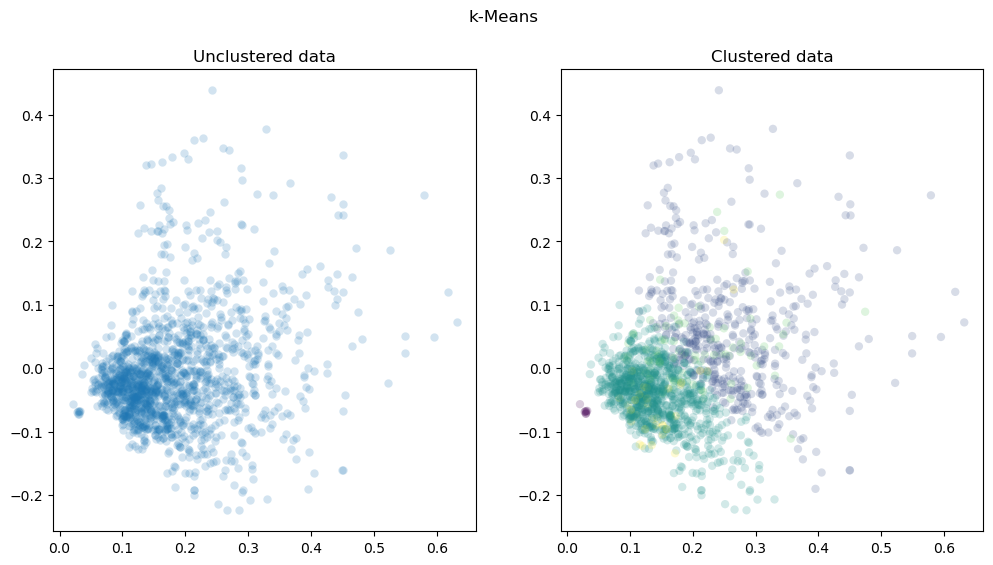

In [19]:
# k-Means clustering with n_clusters = 5

kmeans_5 = KMeans(n_clusters=5, n_init='auto')

# Perform clustering and return labels
clusters_5 = kmeans_5.fit_predict(X_texts)

# Print label vector shape
print("kMeans label vector shape:", clusters_5.shape)

# Plot results
plot_compare(X_texts, clusters_5, 'k-Means')

In [20]:
cluster_labels2 = kmeans_5.labels_

data['cluster'] = cluster_labels2

print(data['cluster'].unique())
data.head(10)

[2 1 3 4 0]


,source_id,text,pub_date,decade,gender,ethnicity,state,cluster
0,eaf001,MONALDI.\nCHAPTER I.\nAmong\nthe students of a...,1841,1840,M,White,MA,2
1,eaf002,THE REGICIDES\nWe dig no lands for tyrants but...,1831,1830,F,White,CT,1
2,eaf003,"The loved, the hated, the adored,\nEach mortal...",1838,1830,F,White,CT,2
3,eaf004,2\nTHE BRIDE OF FORT EDWARD.\nPART FIRST.\nIND...,1839,1830,F,White,CT,2
4,eaf005,LETTER I.\nOriginal State of the\nForest\n.The...,1792,1790,M,White,NH,1
5,eaf006,PART I.\nCHAPTER I.\nINTRODUCTIONTHE TRAVELERS...,1847,1840,M,White,NY,2
6,eaf007,CHAPTER I.\nChange is written on the tide\nOn ...,1848,1840,M,White,NY,2
7,eaf008,CHAPTER I.\nINTRODUCTIONTHE STRANGERTHE ATTACK...,1848,1840,M,White,NY,2
8,eaf009,THE\nTRAPPER'S BRIDE\nCHAPTER I.\nO'er vales t...,1848,1840,M,White,NY,1
9,eaf011,OLIVER GOLDFINCH.\nCHAPTER I.\nTHE HYPOCRITE U...,1850,1850,M,White,NY,2


In [ ]:
pull_samples(texts, sample_list, cluster_labels2, 3)

Label: 0
Sample text: 578
Source ID: Wright2-0803
NO THROUGHFARE.
OVERTURE.
DAY of the month and year, one thousand eight hundred and thirty-five. Boston time by the great clock of the Old South, ten at night. The clock on the Home for Little, Wanderers did not strike as fast as the rest, being probably out of repair. The moon shone brightly. A veiled lady flitters to and fro round the postern gate of said Home. She observes Sally, one of the nurses, and timidly gives her two greenbacks and a bundle, and says, after a little verbal "sparring,"— 

Sample text: 580
Source ID: Wright2-0807
THE CONCEALED TREASURE.
chapter I.
A SOLITARY house stood alone, surrounded by uncultivated fields, which had evidently long been lying fallow. The old mansion was grim, gray, and desolate in its outward appearance: the storms of winter had battled over it, shaking the crazy walls to their foundation, and the summer's sunshine had played upon it, without seeming to impart any portion of its warmth and v

Spectral label vector shape: (1540,)


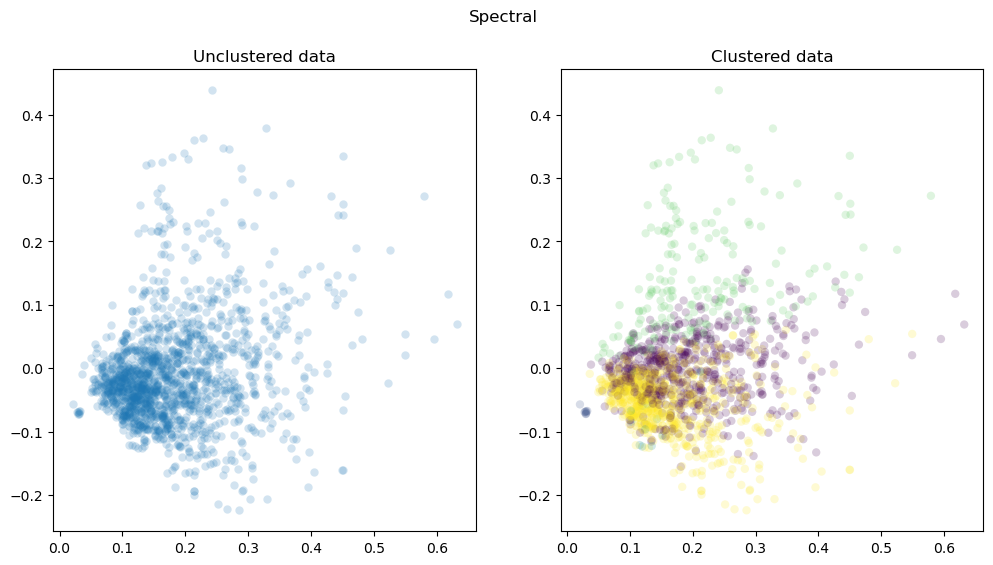

In [24]:
# Your spectral clustering code

# Clustering object
spectral_clusterer = SpectralClustering(
    n_clusters=5,
    affinity='precomputed'
)

# Cosine affinitiy matrix
cosine_affinity = cosine_similarity(X_texts)

# Perform clustering on similarity matrix
y_spectral = spectral_clusterer.fit_predict(cosine_affinity)

# Print label shape
print("Spectral label vector shape:", y_spectral.shape)

# Plot spectral results
plot_compare(X_texts, y_spectral, 'Spectral')

In [25]:
cluster_labels3 = spectral_clusterer.labels_

data['cluster'] = cluster_labels3

print(data['cluster'].unique())
data.head(10)

[3 4 0 2 1]


,source_id,text,pub_date,decade,gender,ethnicity,state,cluster
0,eaf001,MONALDI.\nCHAPTER I.\nAmong\nthe students of a...,1841,1840,M,White,MA,3
1,eaf002,THE REGICIDES\nWe dig no lands for tyrants but...,1831,1830,F,White,CT,4
2,eaf003,"The loved, the hated, the adored,\nEach mortal...",1838,1830,F,White,CT,4
3,eaf004,2\nTHE BRIDE OF FORT EDWARD.\nPART FIRST.\nIND...,1839,1830,F,White,CT,4
4,eaf005,LETTER I.\nOriginal State of the\nForest\n.The...,1792,1790,M,White,NH,0
5,eaf006,PART I.\nCHAPTER I.\nINTRODUCTIONTHE TRAVELERS...,1847,1840,M,White,NY,4
6,eaf007,CHAPTER I.\nChange is written on the tide\nOn ...,1848,1840,M,White,NY,4
7,eaf008,CHAPTER I.\nINTRODUCTIONTHE STRANGERTHE ATTACK...,1848,1840,M,White,NY,0
8,eaf009,THE\nTRAPPER'S BRIDE\nCHAPTER I.\nO'er vales t...,1848,1840,M,White,NY,0
9,eaf011,OLIVER GOLDFINCH.\nCHAPTER I.\nTHE HYPOCRITE U...,1850,1850,M,White,NY,4


In [48]:
pull_samples(texts, sample_list, cluster_labels3, 3)

Label: 0
Sample text: 13
Source ID: eaf025v1
VOL. I. 1
HARRY FRANCO.
CHAPTER I.
Being the beginning of the Book, is very properly devoted to
the beginning of the Hero.
ANCESTRAL.
It
is a generally received opinion in some parts
of the world, that a man must of necessity have
had ancestors; but, in our truly independent
country, we contrive to get along very well
without
them. That strange race, called Aristocrats,
it is said, consider every body as nobody, unless
they can boast of at least a dozen ancestors. These
lofty people would have s 

Sample text: 548
Source ID: Wright2-0727
THE MASTER.
CHAPTER I.
THE MUSIC-MASTER.
THE sun was setting; but it threw a parting splendor over the high, bleached walls of the great music-room, one end of which was in shadow. Loporta, the music-master, stood opposite his favorite pupil, by the west window. He rapped the board before him with his violin-bow, and smiled, showing deep dimples.
"Well done, Minot! well done!" he cried, in a hearty voice; "y

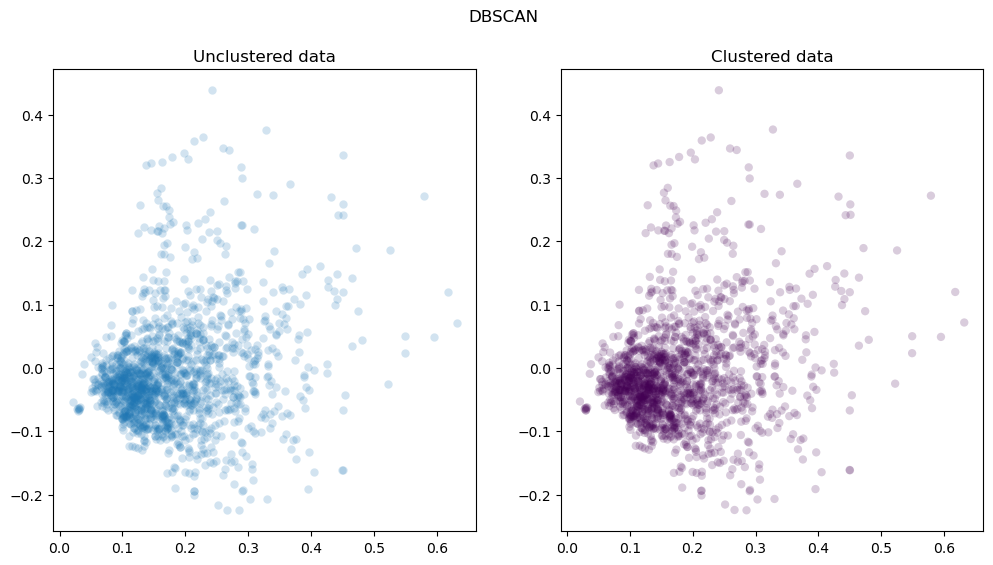

In [27]:
# Density-based Clustering

density_clusterer = DBSCAN(
    metric='cosine',
    min_samples=10,
    eps=0.5
)
y_dbscan = density_clusterer.fit_predict(X_texts)
plot_compare(X_texts, y_dbscan, 'DBSCAN')

In [28]:
cluster_labels4 = density_clusterer.labels_

data['cluster'] = cluster_labels4

print(data['cluster'].unique())
data.head(10)

[-1]


,source_id,text,pub_date,decade,gender,ethnicity,state,cluster
0,eaf001,MONALDI.\nCHAPTER I.\nAmong\nthe students of a...,1841,1840,M,White,MA,-1
1,eaf002,THE REGICIDES\nWe dig no lands for tyrants but...,1831,1830,F,White,CT,-1
2,eaf003,"The loved, the hated, the adored,\nEach mortal...",1838,1830,F,White,CT,-1
3,eaf004,2\nTHE BRIDE OF FORT EDWARD.\nPART FIRST.\nIND...,1839,1830,F,White,CT,-1
4,eaf005,LETTER I.\nOriginal State of the\nForest\n.The...,1792,1790,M,White,NH,-1
5,eaf006,PART I.\nCHAPTER I.\nINTRODUCTIONTHE TRAVELERS...,1847,1840,M,White,NY,-1
6,eaf007,CHAPTER I.\nChange is written on the tide\nOn ...,1848,1840,M,White,NY,-1
7,eaf008,CHAPTER I.\nINTRODUCTIONTHE STRANGERTHE ATTACK...,1848,1840,M,White,NY,-1
8,eaf009,THE\nTRAPPER'S BRIDE\nCHAPTER I.\nO'er vales t...,1848,1840,M,White,NY,-1
9,eaf011,OLIVER GOLDFINCH.\nCHAPTER I.\nTHE HYPOCRITE U...,1850,1850,M,White,NY,-1


In [47]:
pull_samples(texts, sample_list, cluster_labels4, 3)

Label: -1
Sample text: 692
Source ID: Wright2-1686
DIFFERENCES.
A NOVEL.
CHAPTER I.
THERE is a glitter and a fragrance in the mere name of the South, which are associated with sunny skies and exuberant vegetation. Like a Nile of the new world the Mississippi pours its vast stream; it is bordered by bluffs, that are pyramids of God's own making; and in their soil repose chieftains, that have never been tyrants, surrounded by warriors, that have never been slaves.
These exquisitely German reflections passed through the mind of Louis Welland, as th 

Sample text: 88
Source ID: eaf134v2
PART II. 2
MOSSES FROM AN OLD MANSE.
THE NEW ADAM AND EVE.
We,
who are born into the world's artificial system, can never
adequately know how little in our present state and circumstances
is natural, and how much is merely the interpolation of the
perverted
mind and heart of man. Art has become a second and
stronger Nature; she is a step-mother, whose crafty tenderness
has taught us to despise the bountiful

After taking a closer look into each text of the first cluster method (KMeans Clustering with 3 clusters), it doesn't seem like metadata such as publication year, location published, author's gender, race, main state of residence have much impact on the clustering. In most of these texts, author's are most associated with states in the northeast region such as NY, NJ, PA, and MA. They are mostly all white male authors except for two white female authors. There also is a range of occupations spanning from church minister to sailor. The year in which they were published ranges from 1824-1861 for the first cluster, 1843-1860 for the second cluster, and 1847-1859 for the last cluster. Thus, it does not seem like these features have a big influence on the clusterings. When looking at the text samples, it is clear that the first cluster has texts that talk about nature yet also about heroes as, on the one hand, they have words like solitary shore, sandy bay, ocean's roar, winds, and waters, and on the other hand, words like bold, cry, hero, heroine, and political freedom. In the second cluster, the sentiment of the texts seem to be generally negative as there are words like sinners, vanity, hardships, poor, fleeing, and persecution. In the last cluster, the sentiment also seems to err on the negative side although not as much as the second cluster. It sees the theme of the texts of the last cluster have to do with the country, states, history, and politics. From these analyses we can conclude that it seems these clusters are definitely grouped based on the content of their texts and less so about the metadata of the text. Thus, it does not seem like the year in which these texts were published have a whole lot to do with the themes of the text written which disproves my initial hypotheses although it is notable that we are only looking at three texts of each cluster. We can go on to draw conclusions in the same way for the following cluster methods (KMeans Clustering with 5 clusters, spectral clustering, and DBSCAN).

### LDA Topic Model

In [71]:
vec = CountVectorizer(
    stop_words='english',
    strip_accents='unicode',
    lowercase=True,
    min_df = 10,
    max_df = 0.5,
    max_features=10000
)
X = vec.fit_transform(data['text'])

In [72]:
n_topics = len(decades)
lda = LatentDirichletAllocation(
    n_components=n_topics, # Number of topics to find
    verbose=1,       # Print progress
    max_iter=30,     # Might want more in production work
    evaluate_every=10 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 6191.4186
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 6090.8247
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30, perplexity: 6055.0421


LatentDirichletAllocation(evaluate_every=10, max_iter=30, verbose=1)

In [73]:
def display_topics(model, feature_names, k_top_words, title, n_topics=10):
    fig, axes = plt.subplots(round(n_topics/5), 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-k_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

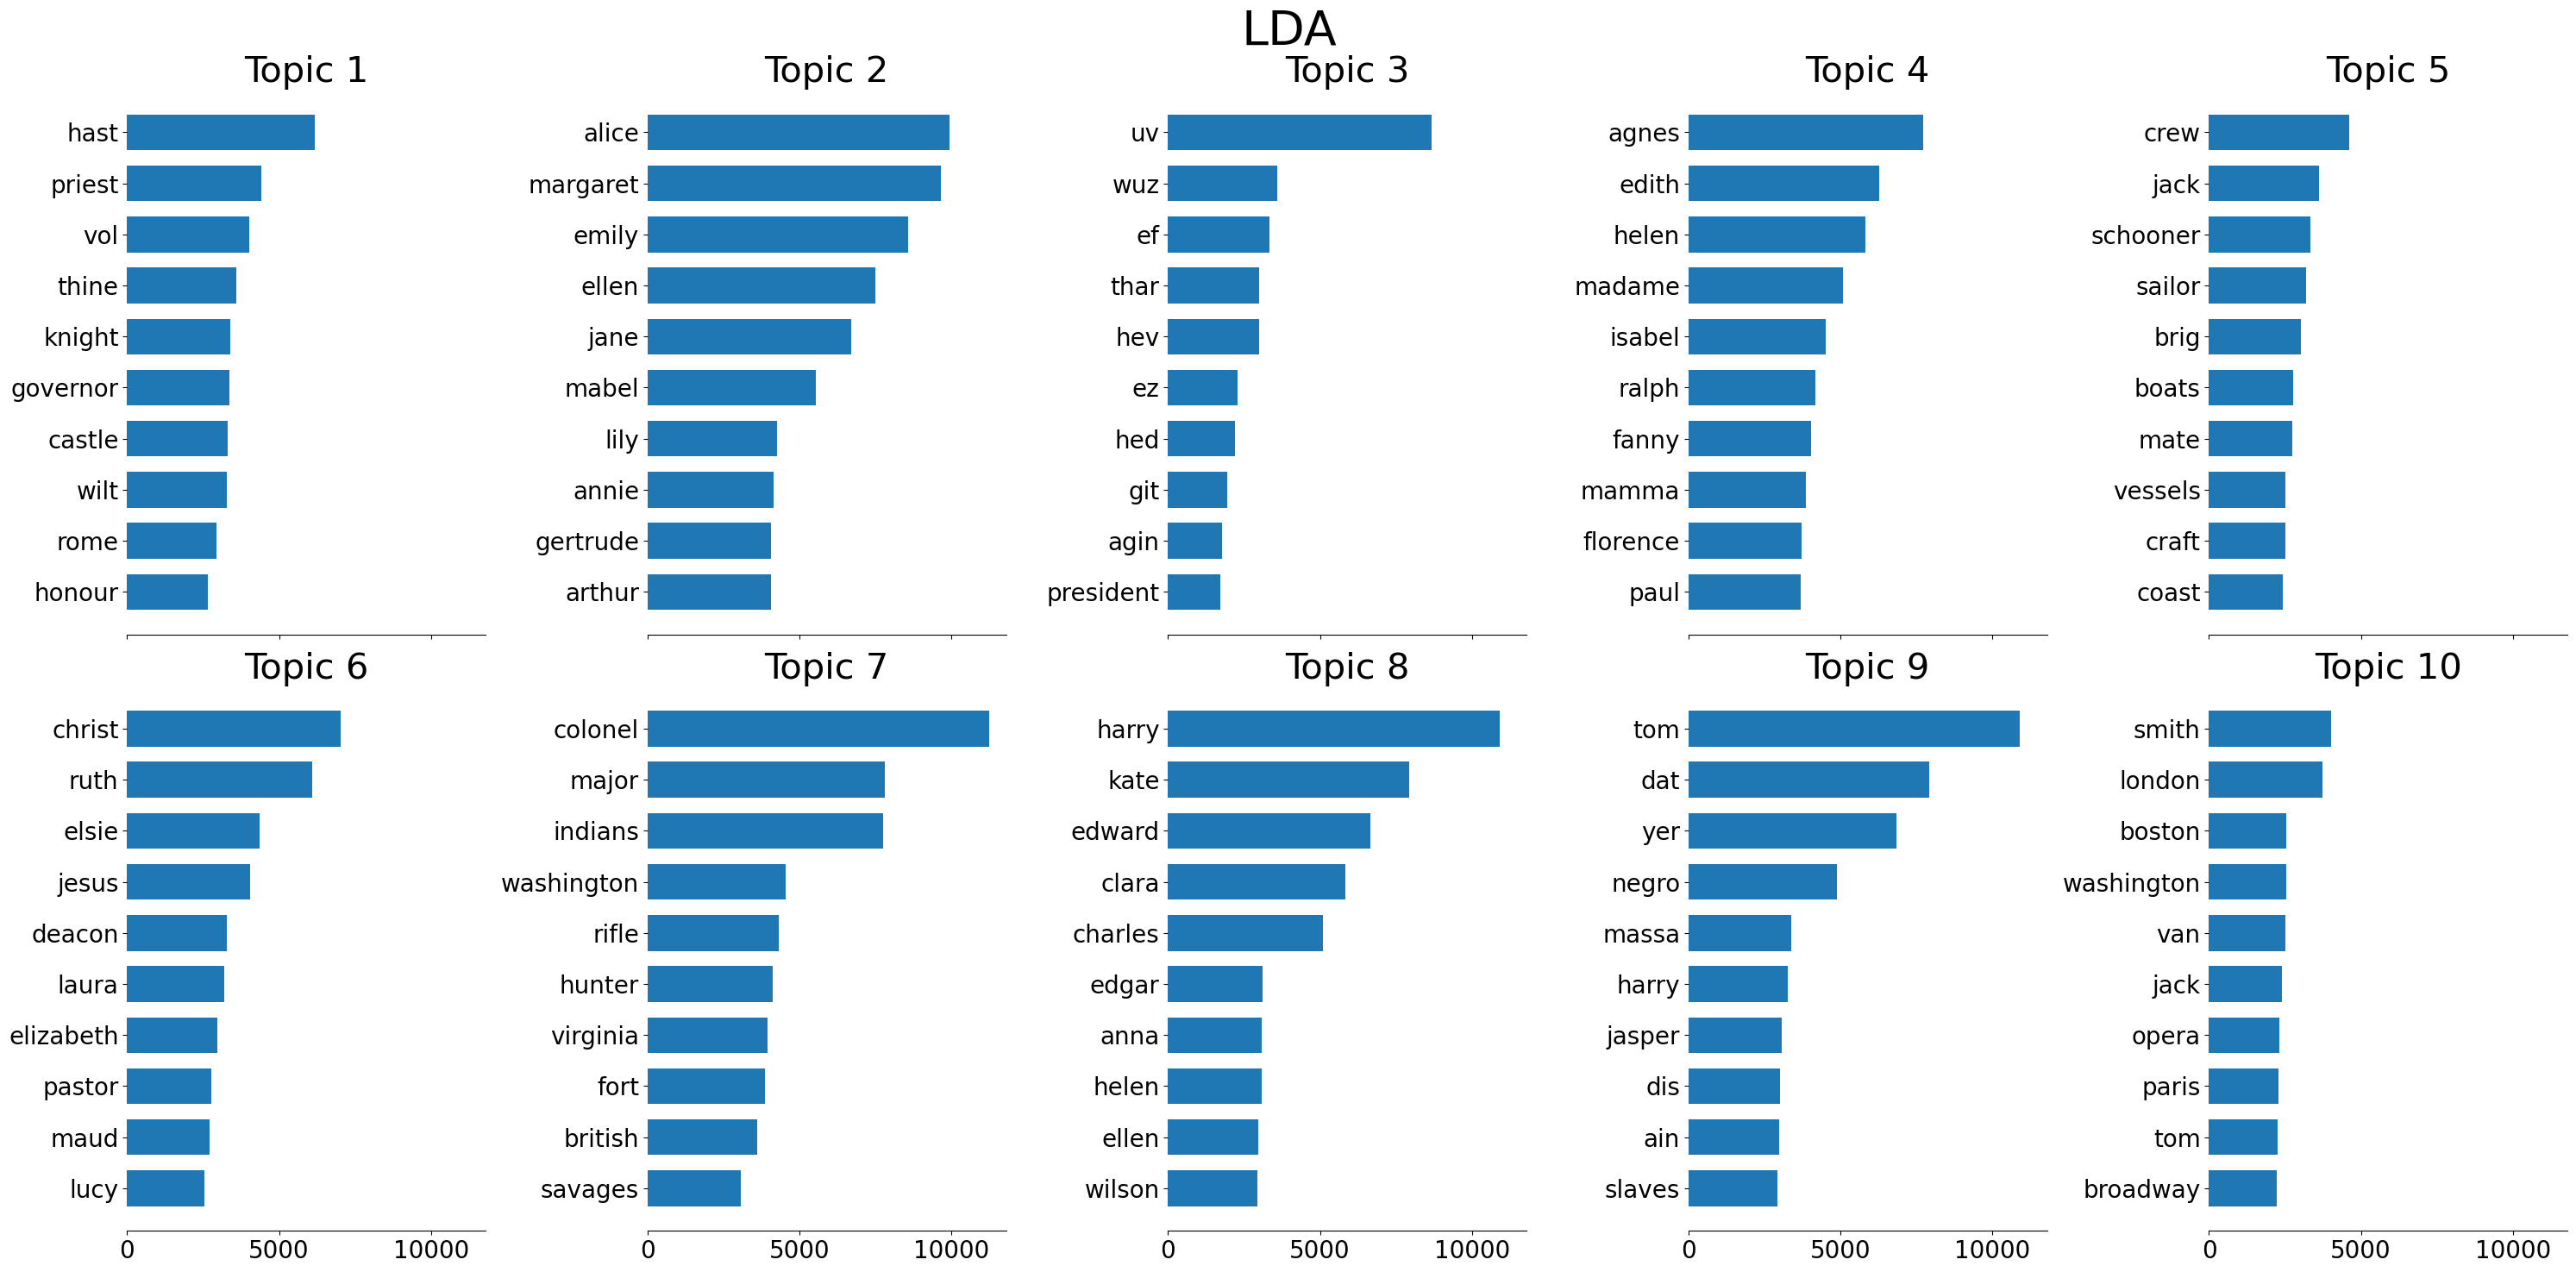

In [74]:
k_words = 10
display_topics(lda, vec.get_feature_names_out(), k_top_words=k_words, n_topics=10, title='LDA')

The LDA topic model shown above shows hidden topics within the given collection of texts and serves to help uncover latent themes or topics present in it. We can see that there are some notable topics that exist in this collection of texts. For example, Topic 6 seems to have to do with religion. It is one of the most prevalent latent topics in these texts which is representative of the time period of the late 18th to 19th century in America as Christianity was the main belief people held. Topic 7 has to do with war, especially involving Native Americans and the British which is also representative of the time period as America had just come out of the Revolutionary War which was won by the US colonies in 1776. Based on the tokens depicted in Topic 9, another major theme is slavery as you can tell by the language used such as "dat" and "yer" which were terms often used by black people at the time since they tended to be uneducated. A last example of a major theme in these texts is boating (Topic 5). This is reflective of this time period as ocean vessels were a major mode of transportation as well as revenue for the colonies through importing and exporting goods. Overall, this LDA topic model shows us that the topics of the texts are reflective and representative of the time period in which these texts were written. 

### Logistic Regression Classification

Here, I performed logistic regression classification to see if I could create a classification model that accurately classifies the decades in which the texts were published or existed. However, as shown by the model performance, the classifier performed very poorly in classifying the correct decade. This shows that perhaps publication year/decade is not a feature that very much defines the texts in this dataset. 

In [411]:
doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

clf = LogisticRegression(
    max_iter=1000
)
y = data['decade']
performance_topics = cross_val_score(clf, doc_topic_matrix, y, scoring='f1_weighted')
print(f"Model performance using topics as features: {np.mean(performance_topics):5.3f}")

Doc-topic matrix shape: (1540, 10)


C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model performance using topics as features: 0.300


In [412]:
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X, y)
print("Token feature input shape:", X_selected.shape)
performance_tokens = cross_val_score(clf, X_selected, y, scoring='f1_weighted')
print(f"Model performance using top tokens as features: {np.mean(performance_tokens):5.3f}")

Token feature input shape: (1540, 20)


C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

Model performance using top tokens as features: 0.273


C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [413]:
svd = TruncatedSVD(n_components=20).fit(X)
X_svd = svd.fit_transform(X)
print("Truncted SVD input shape:", X_svd.shape)

performance_svd = cross_val_score(clf, X_svd, y, scoring='f1_weighted')
print(f"Model performance using SVD components as features: {np.mean(performance_svd):5.3f}")

Truncted SVD input shape: (1540, 20)


C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

Model performance using SVD components as features: 0.261


C:\Users\emmpa\.conda\envs\3350\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 4. Discussion and conclusions
Discussion and conclusions. What does it all mean? Do your results support your hypothesis? Why or why not? What are the limitations of your study and how might those limitations be addressed in future work?

Overall, my results generally do not support my hypothesis that features like publication year/decade and region in which author's reside affect the themes present in the text. From clustering, we see that the clusters are likely grouped based on the content of their texts and not so much based on the metadata of the text such as its publication year. This implies that texts with similar themes or content tend to cluster together, indicating that the inherent characteristics of the texts play a more significant role in shaping clusters. The observation that the clusters are not strongly associated with publication years contradicts my initial hypothesis. It implies that the temporal aspect, at least as represented by the publication year, may not be a prominent factor in determining thematic similarities among the texts. Similarly, when performing classification, the classification model performed very poorly in being able to accurately classify a text's publication year. The classification model's poor performance in accurately predicting a text's publication year suggests that the model struggled to discern patterns or features indicative of specific time periods. This challenges the idea that publication year is a strong determinant of the thematic content in the studied texts. However, the limitations of this study are many and include our limited data set as well as limited information. Many of the texts had NaN values for information about the author such as their gender, ethnicity, and where they were from. The absence of such information may have hindered the classification model's ability to capture potential associations between author attributes and textual themes. While the results did not align with the initial hypothesis, these findings contribute valuable insights into the factors influencing thematic content in literary works. The emphasis on content-driven clustering and the inability of metadata to strongly influence classification highlight the complexity of understanding and predicting thematic patterns. Future research could benefit from a more extensive dataset, including a diverse range of texts with complete author information. Gathering additional metadata, such as author demographics and literary movements, could also enhance the understanding of the factors shaping thematic content. Furthermore, it would be beneficial to experiment with analysis techniques beyond clustering and classification. Techniques like sentiment analysis might uncover hidden patterns in the textual content.